In [1]:
import numpy as np
from math import pi, sqrt, tanh
from matplotlib import pyplot
from scipy.linalg import block_diag
from ipywidgets import interact

Without imposing boundary condition

In [8]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=6 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
nu=0.#sqrt(2)+0.1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(-1,1,140)*7.5/lB


Lx=8*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx)-pi*Nx/(2*Lx)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx)-pi*Nx/(2*Lx)

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= (-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx**2 /6.0
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = (-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx/4.0
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*(-1+np.exp(1j*k*Lx) )/(k*2*Lx)
        c[ ~ np.isfinite( c )] = 0.5
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(sigma3,np.kron(np.diag(kx) , sigma1))
HeB= -vF*elec*B* np.kron(sigma0,np.kron(y1(k1-k2), sigma2))


Hxm= np.kron(sigma0,np.kron( y0(k2-k1) , m_sc*sigma3))
Hef= -np.kron(sigma0,np.kron( mu_n*y0(k1-k2) + mu_sc*y0(k2-k1), sigma0 ))

En=np.zeros((4*Nx,len(ky_sw)))
Vn=np.zeros((4*Nx,4*Nx,len(ky_sw)), dtype=np.complex64)
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= np.kron(sigma0,np.kron(hbar*vF*ky*np.eye(Nx), sigma2))
    H_t = Hx +Hy + HeB + Hxm + Hef 
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
    
print("Done!")

Done!


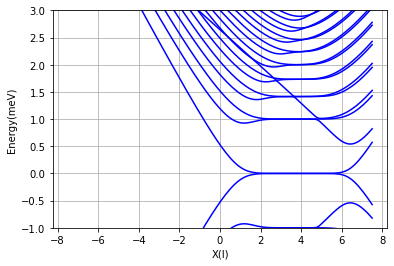

In [10]:
pyplot.figure()
# pyplot.plot(ky_sw/1e9,En.T/meV)
pyplot.plot(ky_sw*lB,En.T/hwc,'b')
pyplot.ylabel("Energy(meV)")
# pyplot.xlabel("ky(1/nm)")
pyplot.xlabel("X(l)")
pyplot.ylim(-1,3)
# pyplot.xlim(-7.5,7.5)
pyplot.grid()
pyplot.show()

In [4]:
def wf_real_space(ev,k,x):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:4*Nx,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p[0:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[1:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0])
            

def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    pyplot.figure(figsize=(10,5))
    pyplot.subplot(2,1,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-1,1)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*10*lB
    wfp_uA,wfp_uB, wfp_dA,wfp_dB =wf_real_space(np.reshape(Vn[:,i_band,:],[4*Nx,len(ky_sw)]),kx,x0)
#     pyplot.figure()
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.subplot(2,1,2)
    pyplot.plot(x0/lB,np.abs(wfp_uA[:,iwf])**2,label=r'$A K1$')
    pyplot.plot(x0/lB,np.abs(wfp_uB[:,iwf])**2,label=r'$B K1$')
    pyplot.plot(x0/lB,np.abs(wfp_dA[:,iwf])**2,label=r'$A K2$')
    pyplot.plot(x0/lB,np.abs(wfp_dB[:,iwf])**2,label=r'$B K2$')
    pyplot.legend()
    pyplot.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(2*Nx-int(nu**2)-3,2*Nx+int(nu**2)+3));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(197, 198, 199, 200, 201, 202), value=197), IntSl…